## Introducción

### Modelo Prophet

Prophet es una biblioteca de código abierto creada por Facebook que implementa un procedimiento de pronóstico que tiene en cuenta tendenciamos no libneales con múltiples periodos estacionales, como anual, mensual, semanal y diario. El paquete permite pronosticar rápidamente con un trabajo manual mínimo y los usuarios más avanzados pueden ajustar el modelo para asegurarse de obtener los mejores resultados posibles.

Prophet implementa un modelo aditivo general en el que cada serie temporal $y(t)$ se modela como la combinación de una tendencia $g(t)$, un componente estacional $s(t)$, efectos de vacaciones $h(t)$ y un término de error $e_t$, que se distribuye normalmente. Matemáticamente, esto se expresa como la ecuación 

$$ y(t) = g(t) + s(t) + h(t) + e_t$$


### Tendencia

#### Tendencia lineal

El primer modelo de tendencia predeterminado es un modelo lineal por partes simple con una tasa de crecimiento constante. Es más adecuado para problemas sin saturar el crecimiento y aprovecha el hecho de que una amplia clase de formas se puede aproximar mediante una función lineal por partes. 

$$g(t) = (k + a(t)^T \delta)t + (m + a(t)^T \gamma)$$

Por defecto, Prophet estima 25 puntos de cambio en el modelo, más del 80% del conjunto de datos (esos parámetros se pueden ajustar). Los puntos de cambio se definen como cambios en la trayectoria, que se pueden estimar o proporcionar manualmente; esta última opción es útil si se dispone de conocimientos de dominio.

El componente de tendencia modela los cambios no periódicos a largo plaza en las series temporales.

El componente estacional modela el cambio periódico, ya sea anual, mensual, semanal o diario. El efecto de vacaciones ocurre irregularmente y potencialmente en más de un día. Finalmente, el término de error representa cualquier cambio en el valor que no puede ser explicado por los 3 componentes anteriores.

Hay que tener en cuenta que este modelo no tiene en cuenta la dependencia temporal de los datos, a diferencia del modelo ARIMA, donde los valores futuros dependen de los valores pasados. Por tanto, este proceso está más cerca de ajustar de ajustar una curva a los datos que de encontrar el proceso subyacente. Aunque hay cierta pérdida de información predictiva con este método, tiene la ventaja de que es muy flexible, ya que puede adaptarse a múltiples periodos estacionales y tendencias cambiantes. Adenás, es resistente a valores atípicos y datos faltantes, lo que es una clara ventaja en un contexto empresarial.

#### Crecimiento no lineal

El primero se llama crecimiento no lineal de saturación. Se representa en la forma del modelo de crecimiento logístico:

$$g(t) = \frac{C}{1 + exp(-k(t-m))},$$

donde $C$ es la cota de saturación (valor máximo) y $k$ es la tasa de crecimiento ('incilinación' de la curva de tendencia). $C$ y $k$ pueden ser constantes o variables en el tiempo. Esta ecuación logística permite modelar el crecimiento no lineal con saturación; es decir, cuando la tasa de crecimiento de un valor disminuye con su crecimiento. Prophet admite el ajuste automático y manual de su variabilidad. La biblioteca puede elegir puntos óptimos de cambios de tendencia ajustando los datos históricos suministrados.

### Estacionalidad

Cuando se trata de datos en aplicaciones prácticas, con frecuencia es tener en cuenta múltiples patrones estacionales que ocurren en paralelo. Un ejemplo clásico serían los datos relacionados con el consumo de energía: hay patrones matutinos vs vespertinos (intradiario), laborales vs fin de semana (semanal) y durante el año (anual). Modelarlos explícitamente tiende a ser engorroso (es necesario agregar más ecuaciones en el suavizado exponencial o introducir dummies en ARIMA), que es uno de los problemas que Prophet fue diseñado para superar. Por tanto, para tener en cuenta múltiples periodos estacionales, Prophet usa las series de Fourier para modelar múltiples efectos periódicos. Específicamente, el componente estacional $s(t)$ se expresa como la siguiente ecuación:

$$
\sum_{n=1}^{N} \left(a_n cos\left(\frac{2 \pi i n}{P}\right) + b_n sin\left(\frac{2 \pi i n}{P}\right)\right),
$$

donde:
* $P$ es la duración del periodo estacional en días.
* $N$ es el número de términos en la serie de Fourier.
* Las funciones seno y coseno forman una base ortogonal.
* Esto significa que cada función se puede representar como una combinación como en la ecuación definida anteriormente.
* Cortando la expansión por un determinado $N$, podemos eliminar las oscilaciones de alta frecuencia --> filtro de paso bajo.

Si tenemos una estacionalidad anual, $P=365,25$ ya que hay $365,25$ días en un año. Para una estacionalidad semanal, $P=7$. $N$ es simplemente el número de parámetros que deseamos usar para estimar el componente estacional. Esto tiene el beneficio adicional de que la sensibilidad del componente estacional se puede ajustar dependiendo de cuántos parámetros $N$ se estimenpara modelar la estacionalidad. Por defecto, Prophet usa 10 términos para modelar la estacionalidad anual y 3 términos para modelar la estacionalidad semanal.

### Días especiales

Finalmente, este modelo nos permite considerar el efecto de las vacaciones. Los días festivos son eventos irregulares que pueden tener un claro impacto en una serie temporal. Por ejemplo, eventos como el Black Friday en EEUU pueden aumentar drásticamente la asistencia a las tiendas o las ventas en un sitio web de comercio electrónico. De manera similar, el Día de San Valentín es probablemente un fuerte indicador de un aumento en la venta de chocolates y flores. Por lo tanto, para modelar el impacto de los días festivos en una serie temporal, Prophet nos permite definir una lista de días festivos para un país específico. Luego, se incorporan los efectos de las vacaciones en el modelo, asumiendo que todos son independiento. Si un punto de datos cae en una fecha de vacaciones, se calculan los $\kappa_i$ para representar el cambio en la serie temporal en ese momento. Cuanto mayor sea el cambio, mayor será el efecto de las vacaciones.

El enfoque de Prophet para modelar días anormales es proporcioanr una lista personalizada de eventos. Suponemos que los efectos son independientes, por lo que, por ejemplo, si un evento deportivo tiene lugar cerca de un día festivo, sus efectos se capturan por separado.

### Cargando librerías

In [2]:
"""
pip install numpy
pip install pandas numpy matplotlib statsmodels
pip install plotly
pip install pandas numpy matplotlib statsmodels plotly seaborn
pip install prophet
pip install scikit-learn
pip install --upgrade nbformat

"""

'\npip install numpy\npip install pandas numpy matplotlib statsmodels\npip install plotly\npip install pandas numpy matplotlib statsmodels plotly seaborn\npip install prophet\npip install scikit-learn\npip install --upgrade nbformat\n\n'

In [3]:
# Manipulación y tratamiento de datos
import numpy as np
import pandas as pd

# Time Series y pruebas
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Ocultar mensajes de warning
import warnings

warnings.filterwarnings("ignore")

# Plots
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

plt.style.use("fivethirtyeight")
plt.rcParams["lines.linewidth"] = 1.5
dark_style = {
    "figure.facecolor": "#212946",
    "axes.facecolor": "#212946",
    "savefig.facecolor": "#212946",
    "axes.grid": True,
    "axes.grid.which": "both",
    "axes.spines.left": False,
    "axes.spines.right": False,
    "axes.spines.top": False,
    "axes.spines.bottom": False,
    "grid.color": "#2A3459",
    "grid.linewidth": "1",
    "text.color": "0.6",
    "axes.labelcolor": "0.6",
    "xtick.color": "0.6",
    "ytick.color": "0.6",
    "font.size": 12,
}
plt.rcParams.update(dark_style)

# Definir el tamaño del gráfico
from pylab import rcParams

rcParams["figure.figsize"] = (18, 7)

In [4]:
# Definir el modelo
from prophet import Prophet

### Cargando los datos

In [5]:
df = pd.read_csv(
    "C:/Users/Juanfran cd/Desktop/MATEMATICAS UA/TFG/air traffic.csv",
    encoding="ISO-8859-1",
)

# Clean and convert 'Pax' to number
df["Pax"] = df["Pax"].str.replace(",", "", regex=True).astype(float)

# Create date column in YYYY-MM format
df["Date"] = pd.to_datetime(
    df["Year"].astype(str) + "-" + df["Month"].astype(str).str.zfill(2), format="%Y-%m"
)

# Filter data between 2003 and 2019 and select relevant columns
df1 = df.loc[df["Year"].between(2003, 2019), ["Date", "Pax"]].copy()

In [6]:
df1.head()

,Date,Pax
0,2003-01-01,47938280.0
1,2003-02-01,45412146.0
2,2003-03-01,55001313.0
3,2003-04-01,51378704.0
4,2003-05-01,53763186.0


## 1. EXPLORATORY DATA ANALYSIS (EDA)

Verifique si los datos están configurados en el formato adecuado y luego comience a modelar/pronosticar.

In [7]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 204 entries, 0 to 203
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    204 non-null    datetime64[ns]
 1   Pax     204 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.8 KB


## 2. DATA VISUALIZATION

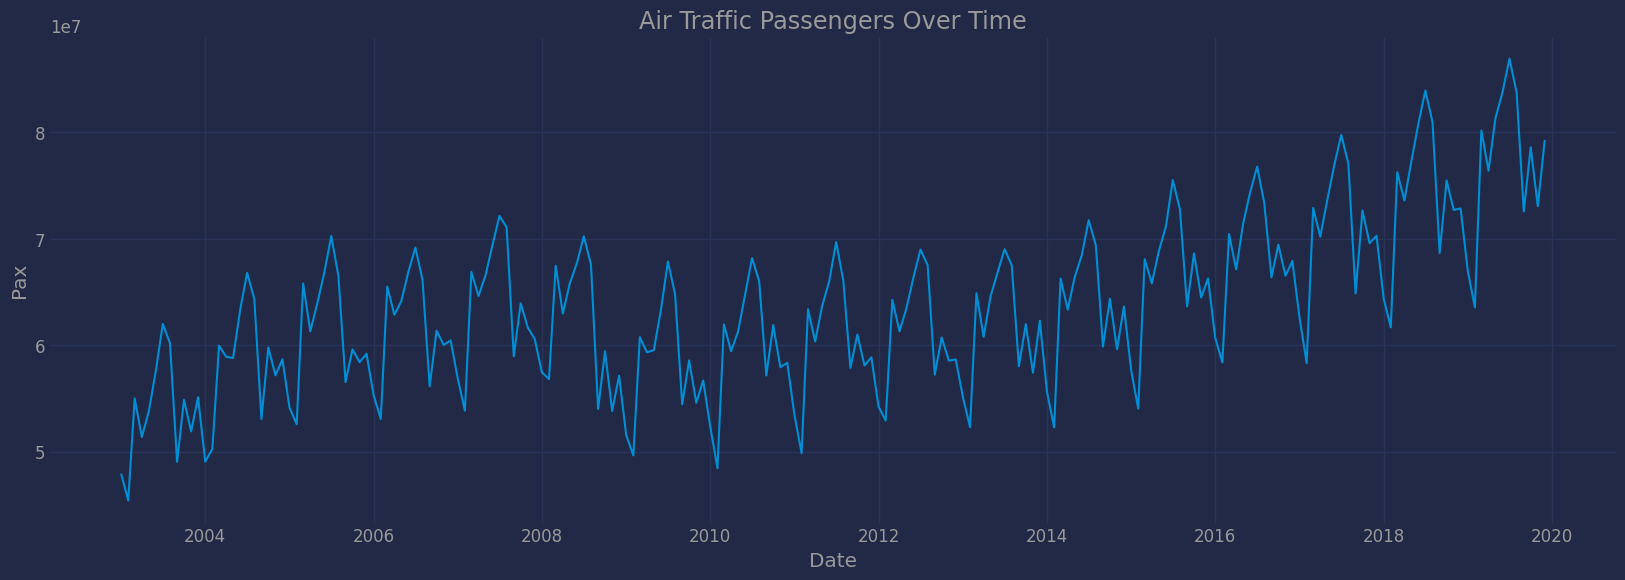

In [8]:
plt.figure(figsize=(18, 6))
sns.lineplot(data=df1, x="Date", y="Pax")
plt.title("Air Traffic Passengers Over Time")
plt.grid(True)
plt.show()

In [9]:
# Prophet no requiere explícitamente que la serie sea estacionaria, pero es una buena práctica
# hacer que la serie sea estacionaria para que el modelo pueda capturar mejor las tendencias y los patrones.


def AUGMENTED_DICKEY_FULLER_TEST_FUNC(series, column_name):
    print(f"Dickey-Fuller test results for column: {column_name}")
    dftest = adfuller(series, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "No Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusions:")
        print("Reject the null hypothesis")
        print("The data is stationary")
    else:
        print("Conclusions")
        print("Do not reject the null hypothesis")
        print("The data is not stationary")

In [10]:
AUGMENTED_DICKEY_FULLER_TEST_FUNC(df1["Pax"], "Pax")

Dickey-Fuller test results for column: Pax
Test Statistic                   0.545193
p-value                          0.986184
No Lags Used                    15.000000
Number of Observations Used    188.000000
Critical Value (1%)             -3.465620
Critical Value (5%)             -2.877040
Critical Value (10%)            -2.575032
dtype: float64
Conclusions
Do not reject the null hypothesis
The data is not stationary


Tenemos una serie no estacionario, pero no hace falta hacerla estacionaria porque Prophet, a diferencia de otros modelos como ARIMA, está diseñado para manejar componentes de tendencia y estacionalidad sin necesidad de diferenciar los datos previamente.

### AutoCorrelación

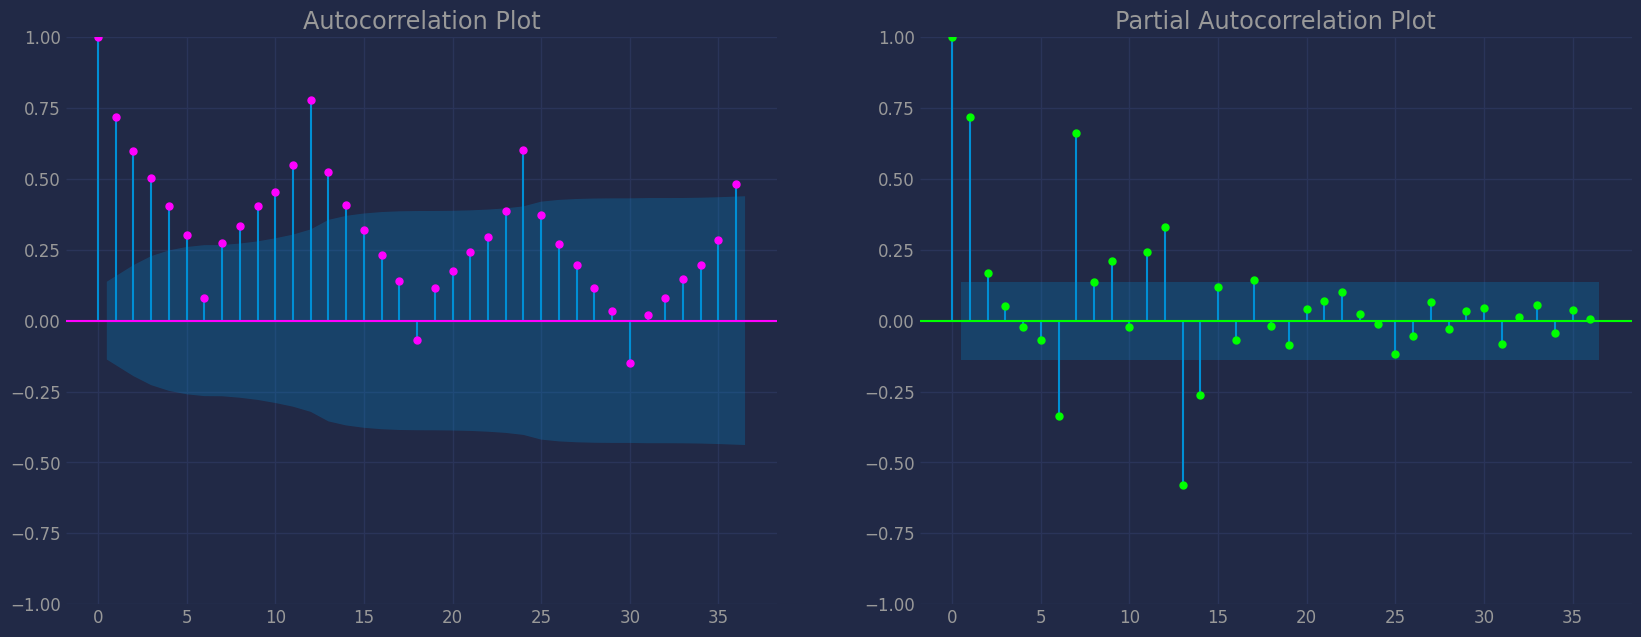

In [11]:
fig, axs = plt.subplots(nrows=1, ncols=2)

plot_acf(df1["Pax"], lags=36, ax=axs[0], color="fuchsia")
axs[0].set_title("Autocorrelation Plot")

plot_pacf(df1["Pax"], lags=36, ax=axs[1], color="lime")
axs[1].set_title("Partial Autocorrelation Plot")

plt.show()

### Descomposition of the time series

¿Cómo descomponer una serie temporal y por qué?

En el análisis de series temporales para pronosticar nuestros valores, es muy importante conocer los datos pasados. De manera más formal, podemos decir que es muy importante conocer los patrones que siguen los valores a lo largo del tiempo. Puede haber muchas razones que hagan que nuestros valores de pronóstico caigan en la dirección equivocada. Básicamente, una serie temporal consta de 4 componentes. La variación de estos componentes provoca el cambio en el patrón de la serie temporal. Estos componentes son:

* Nivel: este es el valor principal que promedia a lo largo del tiempo 
* Tendencia: la tendencia es el valor que provoca patrones crecientes o decrecientes en una serie temporal.
* Estacionalidad: este es un evento cíclico que ocurre en una serie temporal durante un corto periodo de tiempo y causa patrones crecientes o decrecientes a corto plazo en una serie de tiempo.
* Redual/Ruido: esta son las variaciones aleatorias en una serie temporal

La combinación de estos componentes a lo largo del tiempo conduce a la formación de una serie temporal. La mayoría de las series temporales constan de nivel y ruido/residual y la tendencia o estacionalidad son valores opcionales.

Si la estacionalidad y la tendencia son parte de la serie temporal, entonces habrá efectos en el valor previsto. Dado que el patrón de la serie temporal pronosticada puede ser diferente de la serie temporal anterior.

La combinación de los ckmponenres de una serie temporal puede ser de dos tipos:

* Aditivo
* Multiplicativo

#### Serie temporal aditiva

Si se suman los componentes de la serie temporal para formar la serie temporal. Entonces, la serie temporal se llama serie temporal aditiva. Por visualización, podemos decir que la serie temporal es aditiva si el patrón creciente o decreciente de la serie temporal es similar a lo largo de la serie. La función matemática de cualquier serie temporal aditiva se puede representar mediante:

$$ y(t) = \text{level} + \text{Trend} + \text{seasonality} + \text{noise}$$

#### Serie temporal multiplicativa

Si los componentes de la serie temporal son multiplicativos entre sí, entonces la serie temporal se denomina serie de tiempo multiplicativa. Para la visualización, si la serie temporal tiene un crecimiento exponencial o una disminución de tiempo, entonces la serie temporal puede considerarse como una serie temporal multiplicativa. La función matemática de la serie temporal multiplicativa se puede representar como: 

$$ y(t) = \text{level} * \text{Trend} * \text{seasonality} * \text{noise}$$

#### Additive

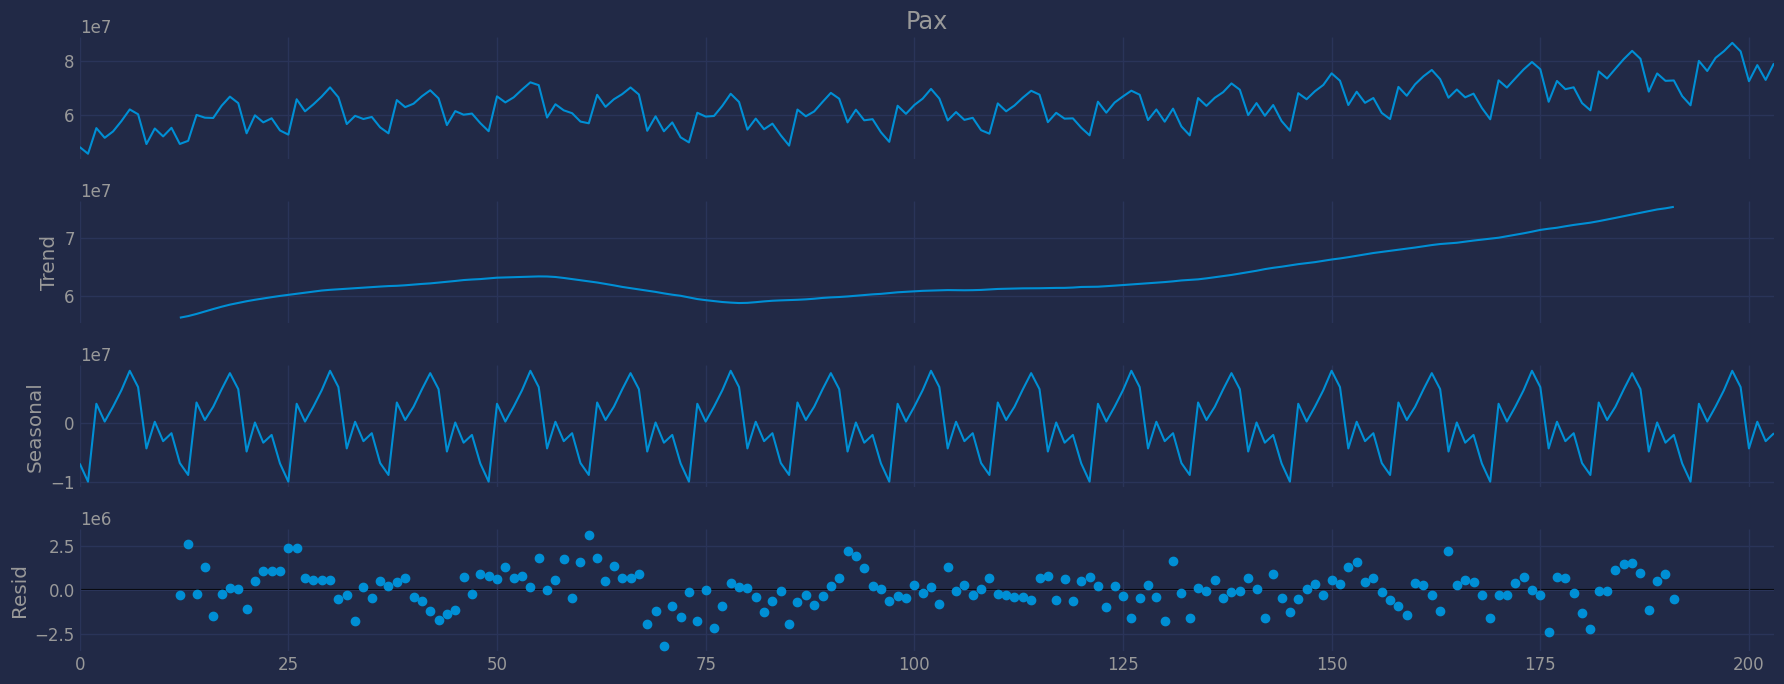

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose

add = seasonal_decompose(df1["Pax"], model="add", period=24)
add.plot();

Se puede ver que hay una tendencia más o menos marcada (creciente) y una estacionalidad. Por otro lado, los residual no se mantienen siempre constantes entorno al 0, lo que no nos garantiza que la serie sea aditiva.

#### Multiplicative

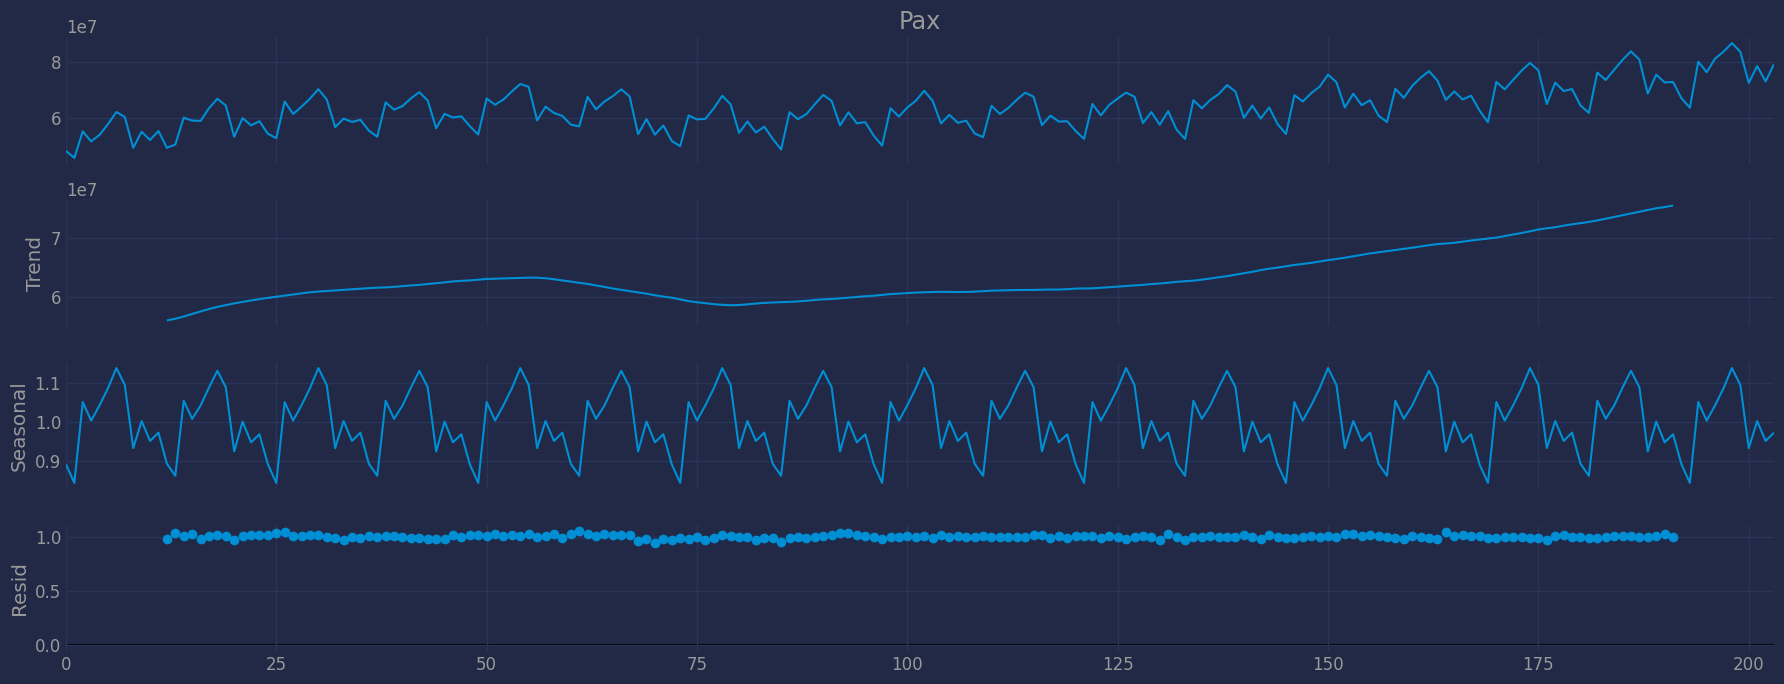

In [13]:
mult = seasonal_decompose(df1["Pax"], model="mul", period=24)
mult.plot();

Los residuals se han trasladado una unidad arriba, lo que nos puede decir que la serie de tiempo que más se adapta es la aditiva en lugar de la multiplicativa.

## 3. División de los datos

In [14]:
train = df1.loc[df1["Date"] <= "2017-12-01"]
test = df1.loc[df1["Date"] >= "2018-01-01"]

train.shape, test.shape

((180, 2), (24, 2))

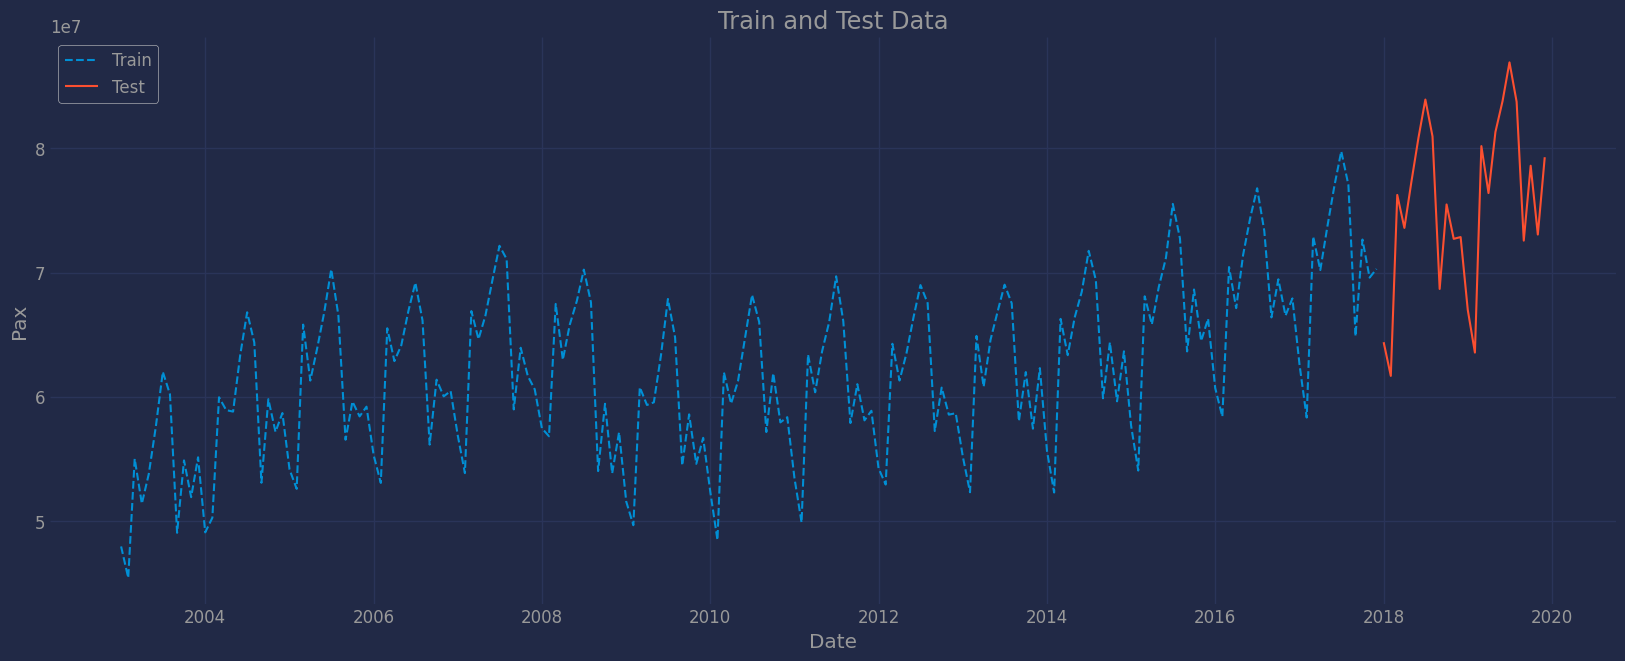

In [15]:
sns.lineplot(data=train, x="Date", y="Pax", label="Train", linestyle="--")
sns.lineplot(data=test, x="Date", y="Pax", label="Test")
plt.title("Train and Test Data")
plt.show()

## 4. Modelando con Prophet

### Creación del Modelo

Prophet espera que el formato de la trama de datos sea específico. El modelo espera una columna ds que contenga el campo de fecha y hora y una columna y que contenga el valores que queremos modelar/pronosticar

In [17]:
train.head()

,Date,Pax
0,2003-01-01,47938280.0
1,2003-02-01,45412146.0
2,2003-03-01,55001313.0
3,2003-04-01,51378704.0
4,2003-05-01,53763186.0


In [18]:
train = train.rename(columns={"Date": "ds", "Pax": "y"})

In [19]:
from prophet import Prophet

model = Prophet()

# Entrenamos el modelo
model.fit(train)

17:56:45 - cmdstanpy - INFO - Chain [1] start processing
17:56:45 - cmdstanpy - INFO - Chain [1] done processing


Ahora, es el momento de comenzar a pronosticar. Con Prophet, comenzamos construyendo algunos datos de tiempo futuro con el siguiente comando:

In [ ]:
future = model.make_future_dataframe(periods=12, freq="M")
future.head()

,ds
0,2003-01-01
1,2003-02-01
2,2003-03-01
3,2003-04-01
4,2003-05-01


In [21]:
len(future)

204

In [22]:
future.tail()

,ds
199,2019-07-31
200,2019-08-31
201,2019-09-30
202,2019-10-31
203,2019-11-30


Ahora, intentamos predecir los valores reales utilizando la biblioteca Prophet y verificar los últimos cinco elementos de pronóstico.

In [23]:
forecast1 = model.predict(future)
forecast1

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2003-01-01,5.263785e+07,4.433575e+07,4.720016e+07,5.263785e+07,5.263785e+07,-6.899260e+06,-6.899260e+06,-6.899260e+06,-6.899260e+06,-6.899260e+06,-6.899260e+06,0.0,0.0,0.0,4.573859e+07
1,2003-02-01,5.296716e+07,4.241869e+07,4.525380e+07,5.296716e+07,5.296716e+07,-9.110568e+06,-9.110568e+06,-9.110568e+06,-9.110568e+06,-9.110568e+06,-9.110568e+06,0.0,0.0,0.0,4.385660e+07
2,2003-03-01,5.326461e+07,5.441108e+07,5.708253e+07,5.326461e+07,5.326461e+07,2.412702e+06,2.412702e+06,2.412702e+06,2.412702e+06,2.412702e+06,2.412702e+06,0.0,0.0,0.0,5.567731e+07
3,2003-04-01,5.359392e+07,5.189507e+07,5.470843e+07,5.359392e+07,5.359392e+07,-3.093819e+05,-3.093819e+05,-3.093819e+05,-3.093819e+05,-3.093819e+05,-3.093819e+05,0.0,0.0,0.0,5.328454e+07
4,2003-05-01,5.391261e+07,5.475700e+07,5.737712e+07,5.391261e+07,5.391261e+07,2.161863e+06,2.161863e+06,2.161863e+06,2.161863e+06,2.161863e+06,2.161863e+06,0.0,0.0,0.0,5.607447e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,2019-07-31,7.624386e+07,8.017236e+07,8.381148e+07,7.511458e+07,7.740681e+07,5.734638e+06,5.734638e+06,5.734638e+06,5.734638e+06,5.734638e+06,5.734638e+06,0.0,0.0,0.0,8.197850e+07
200,2019-08-31,7.644708e+07,7.032706e+07,7.404325e+07,7.520983e+07,7.771202e+07,-4.267845e+06,-4.267845e+06,-4.267845e+06,-4.267845e+06,-4.267845e+06,-4.267845e+06,0.0,0.0,0.0,7.217923e+07
201,2019-09-30,7.664374e+07,7.436457e+07,7.826868e+07,7.530396e+07,7.798869e+07,-3.453487e+05,-3.453487e+05,-3.453487e+05,-3.453487e+05,-3.453487e+05,-3.453487e+05,0.0,0.0,0.0,7.629839e+07
202,2019-10-31,7.684696e+07,7.112064e+07,7.504727e+07,7.538222e+07,7.831199e+07,-3.700203e+06,-3.700203e+06,-3.700203e+06,-3.700203e+06,-3.700203e+06,-3.700203e+06,0.0,0.0,0.0,7.314676e+07


In [24]:
len(forecast1)

204

Si echamos un vistazo a los datos usando .head(), notamos que hay un montón de columnas en el marco de datos de pronóstico. Los importantes (por ahora) son 'ds' (fecha), 'yhat' (pronóstico), 'yhat_lower' y 'yhat_upper' (niveles de incertidumbre).

In [25]:
forecast1[["ds", "yhat", "yhat_lower", "yhat_upper"]].head()

,ds,yhat,yhat_lower,yhat_upper
0,2003-01-01,4.573859e+07,4.433575e+07,4.720016e+07
1,2003-02-01,4.385660e+07,4.241869e+07,4.525380e+07
2,2003-03-01,5.567731e+07,5.441108e+07,5.708253e+07
3,2003-04-01,5.328454e+07,5.189507e+07,5.470843e+07
4,2003-05-01,5.607447e+07,5.475700e+07,5.737712e+07


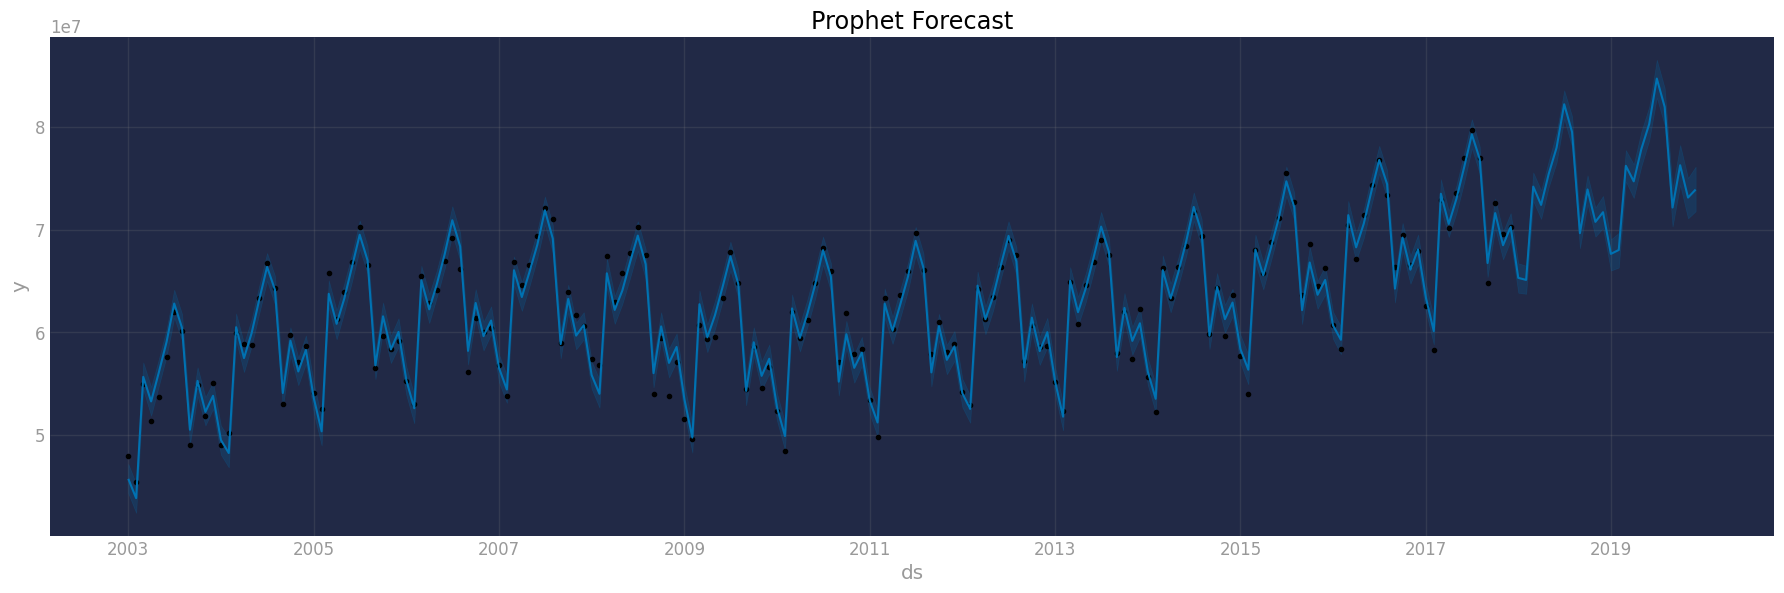

In [26]:
# plt.figure(figsize=(18,6))

model.plot(forecast1, figsize=(18, 6))
plt.title("Prophet Forecast", color="black")
plt.show()

El segundo gráfico que puede obtener el modelo Prophet es una descomposición de los diferentes impactos del modelo. Esto significa que la descomposición puede mostrarle el impacto de las diferentes estacionalidades en cada paso de tiempo.

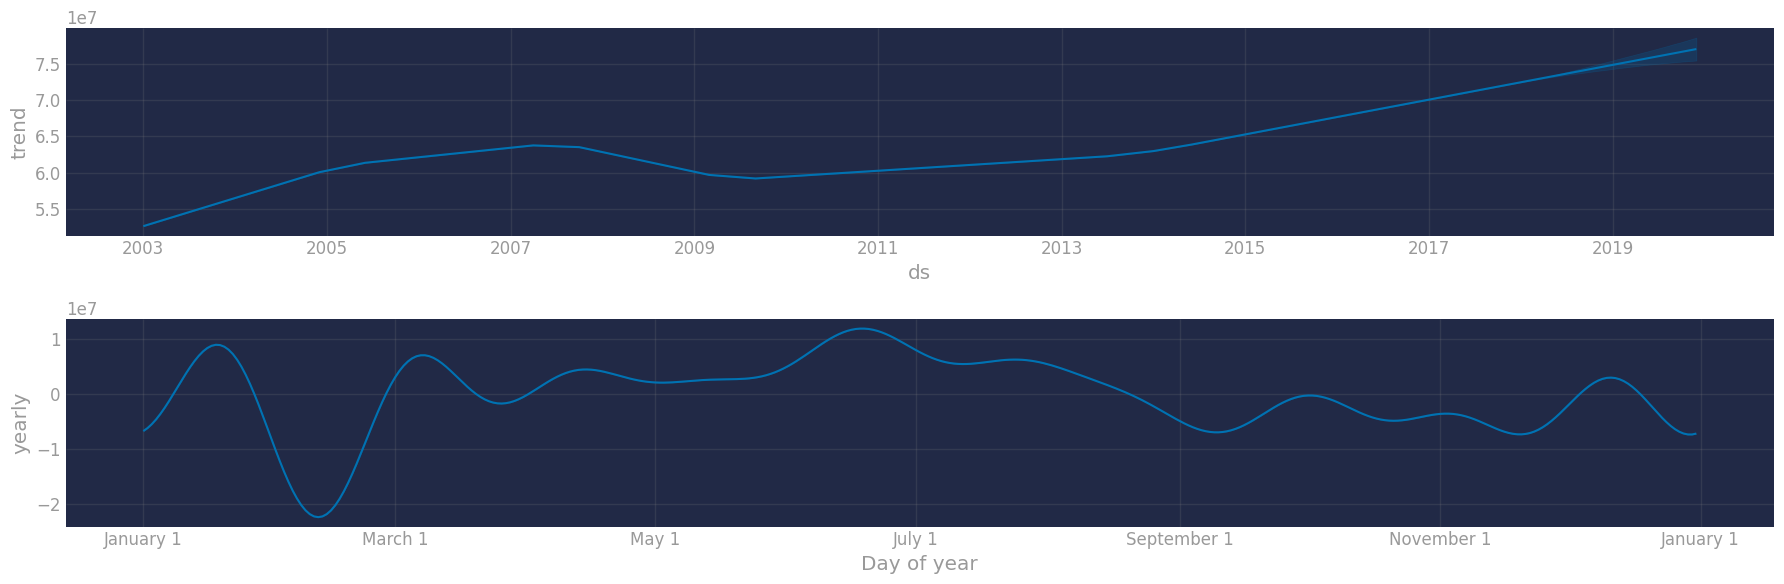

In [27]:
model.plot_components(forecast1, figsize=(18, 6))
plt.show()

### Agregar puntos de cambio a Prophet

Los puntos de cambio son los puntos de fecha (y hora) en los que la serie temporal tiene cambios abruptos en la trayectoria.
Por defecto, Prophet agrega 25 puntos de cambio al 80% inicial del conjuntos de datos.

Tracemos las líneas verticales donde ocurrieron los posibles puntos de cambio.

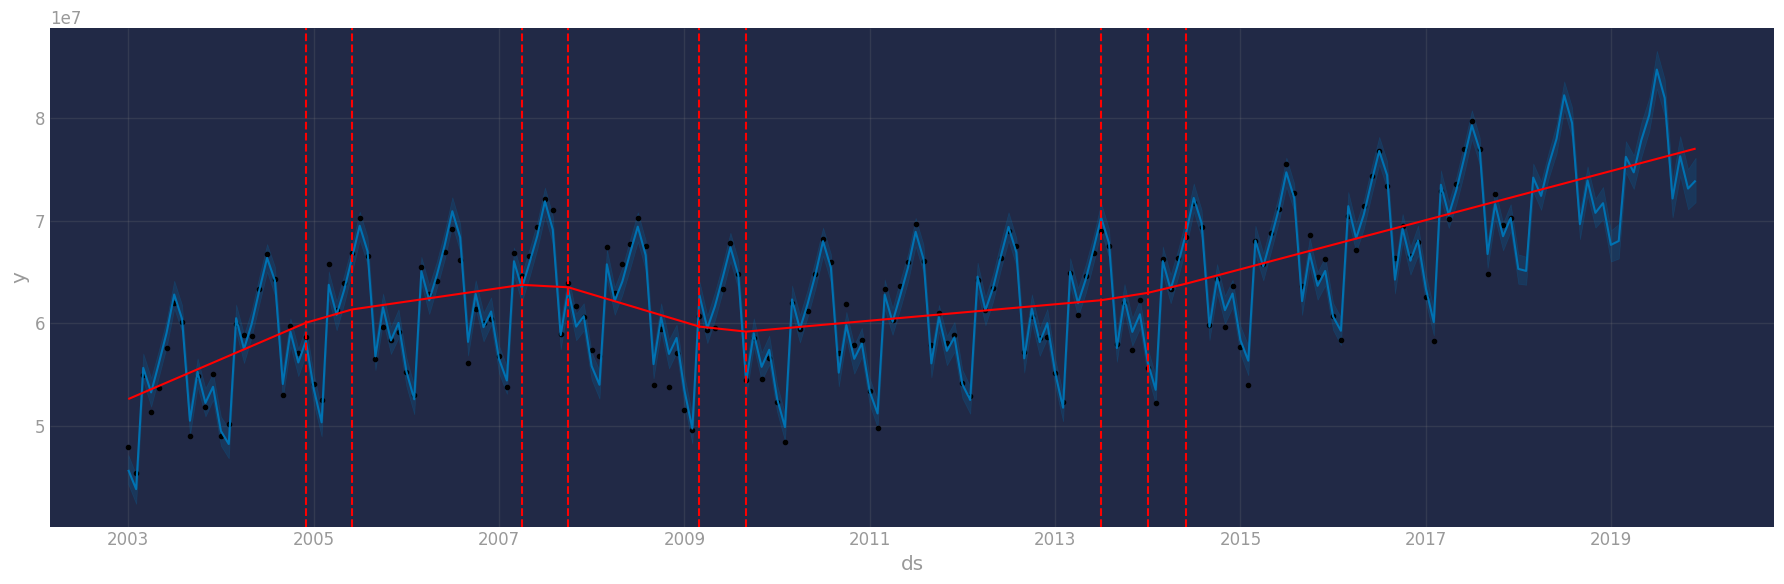

In [28]:
from prophet.plot import add_changepoints_to_plot

# Agregamos los puntos de cambio
fig = model.plot(forecast1, figsize=(18, 6))
a = add_changepoints_to_plot(fig.gca(), model, forecast1)

En este caso tenemos 9 puntos de cambio.

Podemos ver las fechas en las que ocurrieron los puntos de cambio.

In [29]:
model.changepoints

6     2003-07-01
11    2003-12-01
17    2004-06-01
23    2004-12-01
29    2005-06-01
34    2005-11-01
40    2006-05-01
46    2006-11-01
51    2007-04-01
57    2007-10-01
63    2008-04-01
69    2008-10-01
74    2009-03-01
80    2009-09-01
86    2010-03-01
92    2010-09-01
97    2011-02-01
103   2011-08-01
109   2012-02-01
114   2012-07-01
120   2013-01-01
126   2013-07-01
132   2014-01-01
137   2014-06-01
143   2014-12-01
Name: ds, dtype: datetime64[ns]

fechas en las que ocurrieron los puntos de cambio

Podemos cambiar el rango de puntos de cambio inferido configurando *changepoint_range*.

In [1]:
# We add 90% change points
pro_change = Prophet(changepoint_range=0.5)
forecast = pro_change.fit(train).predict(future)
fig = pro_change.plot(forecast, figsize=(18, 6))
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)

NameError: name 'Prophet' is not defined

El número de puntos de cambio se puede configurar usando el parámetro *n_changepoints* al inicializar el Prophet.

17:56:49 - cmdstanpy - INFO - Chain [1] start processing
17:56:49 - cmdstanpy - INFO - Chain [1] done processing


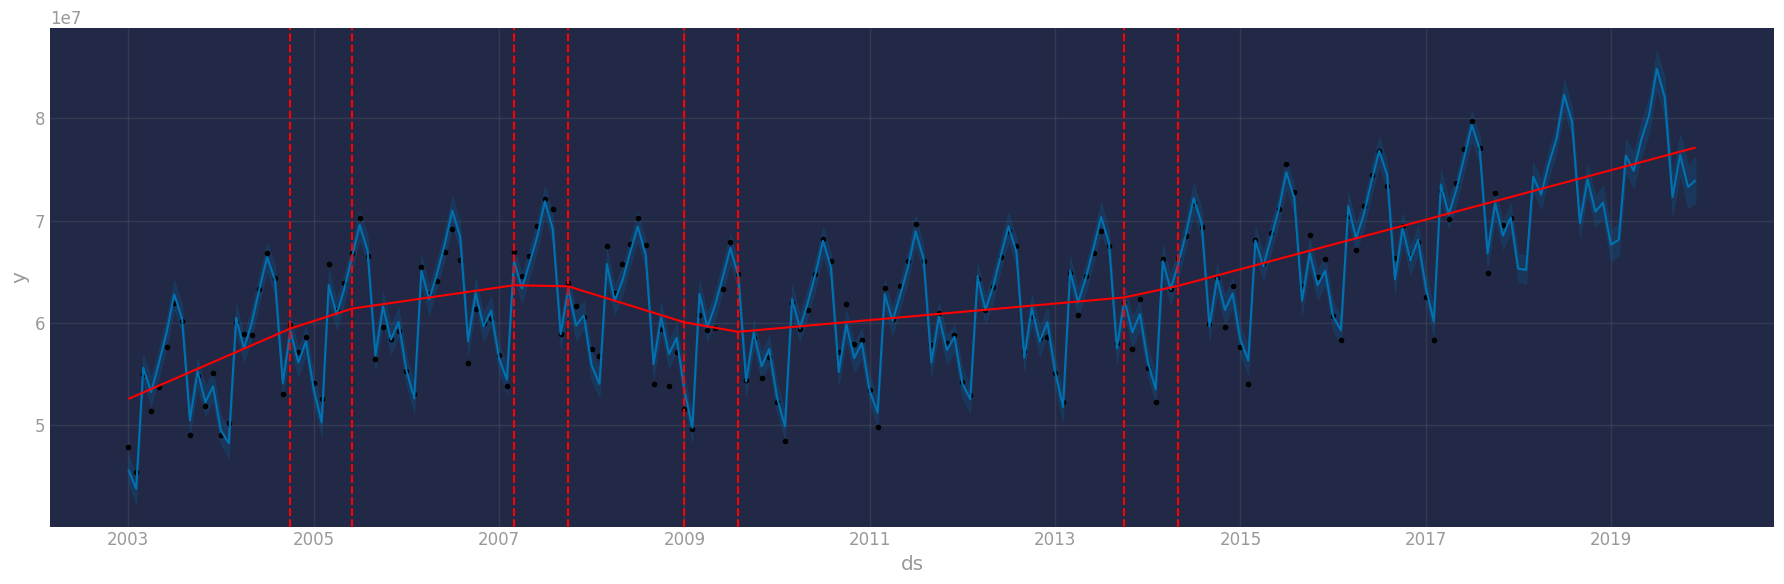

In [31]:
pro_change = Prophet(n_changepoints=20, yearly_seasonality=True)
forecast = pro_change.fit(train).predict(future)
fig = pro_change.plot(forecast, figsize=(18, 6))
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)

### Tendencia de ajuste

Prophet le permite ajustar la tendencia en caso de que haya un sobreajuste o un subajuste. *changepoint_prior_scale* ayuda a ajustar la fuerza de la tendencia.

El valor predeterminado para *changepoint_prior_scale* es 0.05.
* Se disminuye el valor para que la tendencia sea menos flexible.
* Se aumente el valor para que la tendencia sea más flexible.

Aumentar *changepoint_prior_scale* a 0.08 para que la tendencia sea flexible.

17:56:50 - cmdstanpy - INFO - Chain [1] start processing
17:56:50 - cmdstanpy - INFO - Chain [1] done processing


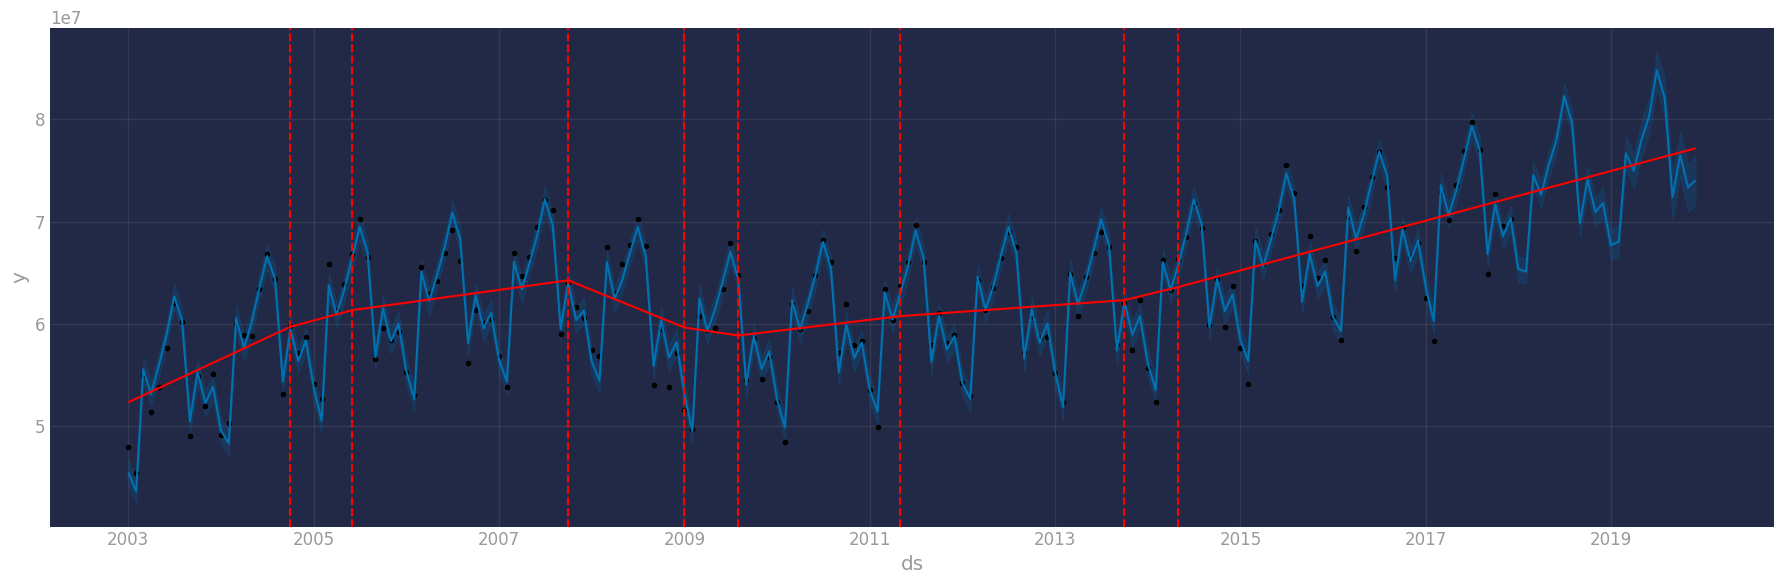

In [32]:
pro_change = Prophet(
    n_changepoints=20, yearly_seasonality=True, changepoint_prior_scale=0.08
)
forecast = pro_change.fit(train).predict(future)
fig = pro_change.plot(forecast, figsize=(18, 6))
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)

Reducir *changepoint_prior_scale* a 0.0001 para que la tendencia sea menos flexible.

17:56:51 - cmdstanpy - INFO - Chain [1] start processing
17:56:51 - cmdstanpy - INFO - Chain [1] done processing


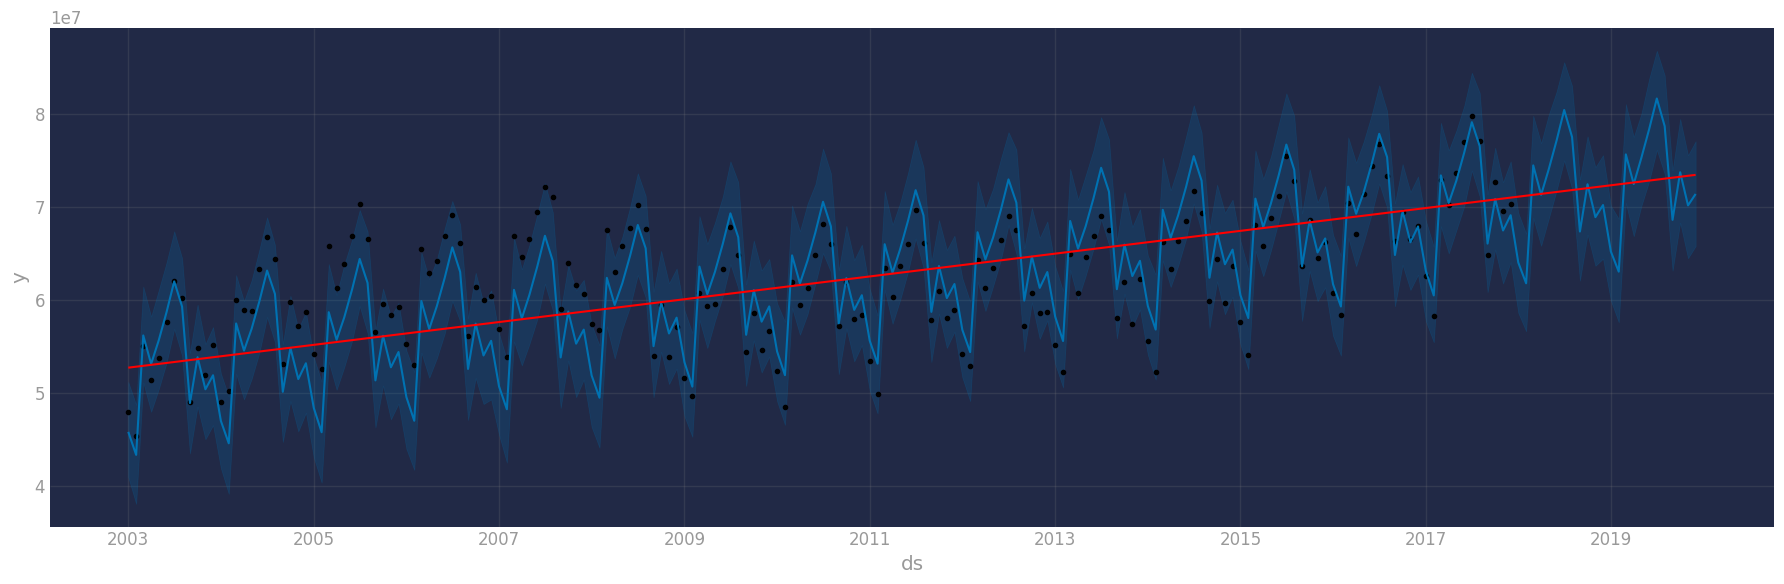

In [33]:
pro_change = Prophet(
    n_changepoints=20, yearly_seasonality=True, changepoint_prior_scale=0.001
)
forecast = pro_change.fit(train).predict(future)
fig = pro_change.plot(forecast, figsize=(18, 6))
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)

### Evaluación del modelo

A continuación, comprobaremos la solidez del modelo utilizando las mejores métricas para medir la precesión de este modelo. Utilizar una combinación de R_Squeared, Mean Squeared Error y Mean Absolute Error nos ayudará a medir la calidad de nuestro modelo.

In [34]:
from sklearn import metrics

y_true = test["Pax"].values
y_pred = forecast1.loc[forecast1["ds"] >= "2017-12-30", "yhat"].values

In [35]:
len(y_true), len(y_pred)

(24, 24)

In [36]:
def EVAL_METRICS_FUNC(y_true, y_pred):
    def MAPE(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    print("Metric evaluation result:-")
    print(f"MSE: {metrics.mean_squared_error(y_true, y_pred)}")
    print(f"MAE: {metrics.mean_absolute_error(y_true, y_pred)}")
    print(f"RMSE: {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}")
    print(f"MAPE: {MAPE(y_true, y_pred)}")
    print(f"R2: {metrics.r2_score(y_true, y_pred)}", end="\n\n")

In [37]:
print(EVAL_METRICS_FUNC(y_true, y_pred))

Metric evaluation result:-
MSE: 6163065815183.655
MAE: 2114325.5496866726
RMSE: 2482552.2784391986
MAPE: 2.798295868655258
R2: 0.8643265315477231

None


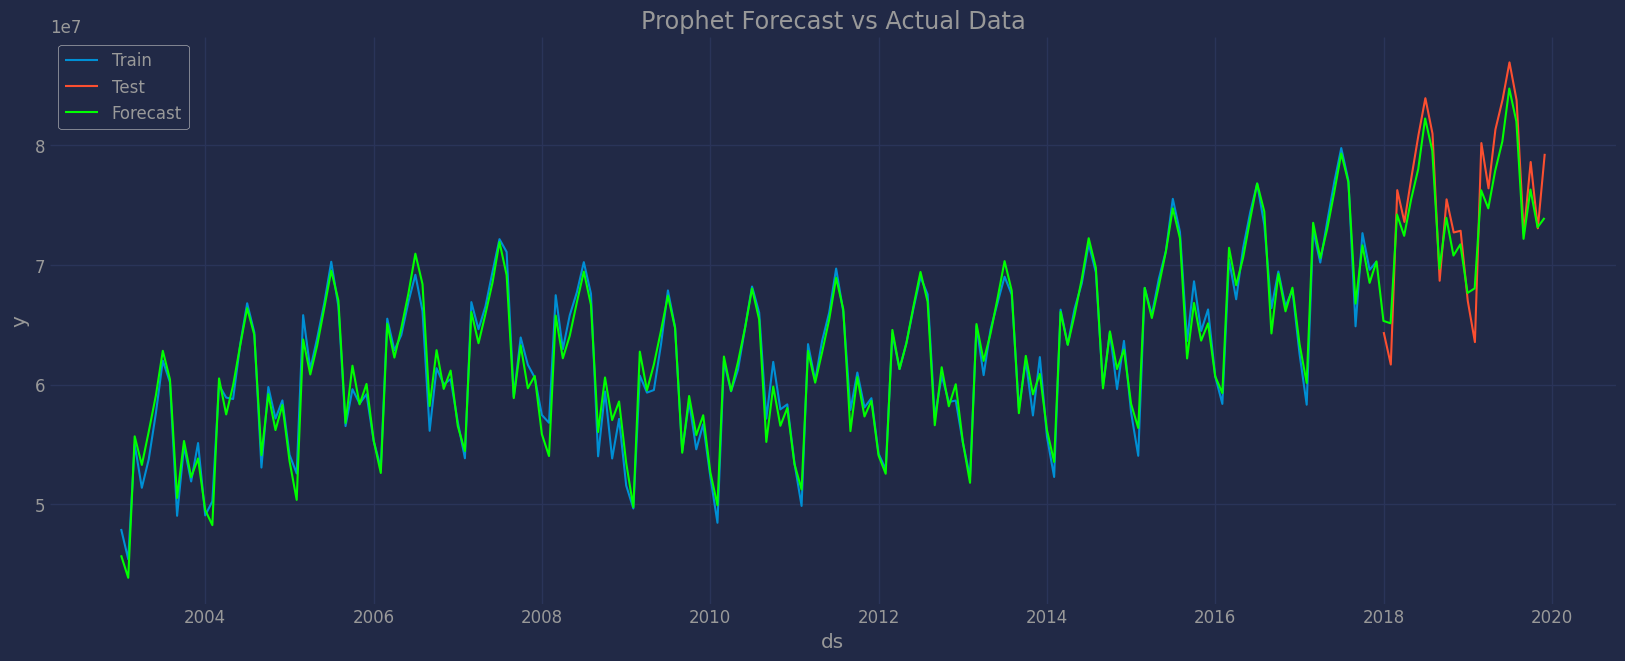

In [38]:
plt.figure(figsize=(18, 7))
sns.lineplot(data=train, x="ds", y="y", label="Train")
sns.lineplot(data=test, x="Date", y="Pax", label="Test")
sns.lineplot(data=forecast1, x="ds", y="yhat", label="Forecast", color="lime")
plt.title("Prophet Forecast vs Actual Data")
plt.grid(True)
plt.show()

### Encontrando mejores parámetros

In [39]:
train["cap"] = 1.0e8  # Por ejemplo, establece una capacidad de 100 millones

In [40]:
print(train.head())

          ds           y          cap
0 2003-01-01  47938280.0  100000000.0
1 2003-02-01  45412146.0  100000000.0
2 2003-03-01  55001313.0  100000000.0
3 2003-04-01  51378704.0  100000000.0
4 2003-05-01  53763186.0  100000000.0


In [41]:
print(train["cap"].dtype)

float64


In [ ]:
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_plotly, plot_components_plotly
from sklearn.metrics import mean_squared_error
from joblib import Parallel, delayed
import itertools


def create_param_combinations(**param_dict):
    param_iter = itertools.product(*param_dict.values())
    params = []
    for param in param_iter:  # Corregido aquí
        params.append(param)
    params_df = pd.DataFrame(params, columns=list(param_dict.keys()))
    return params_df


def train_return_results(param):
    model = Prophet(**param)
    model.fit(train)

    future = model.make_future_dataframe(periods=24, freq="M")
    future["cap"] = 1.0e8
    forecast = model.predict(future)

    return mean_squared_error(df1["Pax"], forecast["yhat"])


param_grid = {
    "changepoint_prior_scale": [0.005, 0.05, 0.5],
    "changepoint_range": [0.8, 0.9, 0.95],
    "seasonality_prior_scale": [0.01, 0.1, 1.0],
    "holidays_prior_scale": [0.01, 0.1, 1.0],
    "seasonality_mode": ["additive", "multiplicative"],
    "growth": ["linear", "logistic"],
    "yearly_seasonality": [5, 10, 20, 50, 100],
}

# Generate all possible combinations of parameters
all_params = create_param_combinations(**param_grid)

# Use cross-validation to evaluate all parameters
rmses = Parallel(n_jobs=-1, verbose=10)(
    delayed(train_return_results)(dict(zip(all_params.keys(), param)))
    for param in all_params.values
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   35.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   

In [43]:
all_params["rmse"] = rmses
best_parameters = dict(all_params.sort_values("rmse").drop("rmse", axis=1).iloc[0])
print(best_parameters)

{'changepoint_prior_scale': np.float64(5.0), 'changepoint_range': np.float64(0.95), 'seasonality_prior_scale': np.float64(1.0), 'holidays_prior_scale': np.float64(10.0), 'seasonality_mode': 'additive', 'growth': 'linear', 'yearly_seasonality': np.int64(5)}


Entrenamos el modelo con los mejores parámetros encontrados

In [44]:
model = Prophet(**best_parameters)
model.fit(train)

future = model.make_future_dataframe(periods=24, freq="M")
forecast_best = model.predict(future)

18:03:55 - cmdstanpy - INFO - Chain [1] start processing
18:03:55 - cmdstanpy - INFO - Chain [1] done processing


In [45]:
forecast_best

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2003-01-01,5.321527e+07,4.550864e+07,4.767620e+07,5.321527e+07,5.321527e+07,-6.680536e+06,-6.680536e+06,-6.680536e+06,-6.680536e+06,-6.680536e+06,-6.680536e+06,0.0,0.0,0.0,4.653473e+07
1,2003-02-01,5.318589e+07,4.292623e+07,4.503493e+07,5.318589e+07,5.318589e+07,-9.241403e+06,-9.241403e+06,-9.241403e+06,-9.241403e+06,-9.241403e+06,-9.241403e+06,0.0,0.0,0.0,4.394449e+07
2,2003-03-01,5.315936e+07,5.490183e+07,5.712440e+07,5.315936e+07,5.315936e+07,2.865092e+06,2.865092e+06,2.865092e+06,2.865092e+06,2.865092e+06,2.865092e+06,0.0,0.0,0.0,5.602445e+07
3,2003-04-01,5.312999e+07,5.209909e+07,5.429621e+07,5.312999e+07,5.312999e+07,1.174546e+05,1.174546e+05,1.174546e+05,1.174546e+05,1.174546e+05,1.174546e+05,0.0,0.0,0.0,5.324744e+07
4,2003-05-01,5.310156e+07,5.413141e+07,5.642010e+07,5.310156e+07,5.310156e+07,2.208868e+06,2.208868e+06,2.208868e+06,2.208868e+06,2.208868e+06,2.208868e+06,0.0,0.0,0.0,5.531043e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,2019-07-31,7.815709e+07,7.705676e+07,9.195789e+07,7.075216e+07,8.564068e+07,6.441512e+06,6.441512e+06,6.441512e+06,6.441512e+06,6.441512e+06,6.441512e+06,0.0,0.0,0.0,8.459860e+07
200,2019-08-31,7.845126e+07,6.593729e+07,8.197955e+07,7.024590e+07,8.646639e+07,-4.395608e+06,-4.395608e+06,-4.395608e+06,-4.395608e+06,-4.395608e+06,-4.395608e+06,0.0,0.0,0.0,7.405565e+07
201,2019-09-30,7.873594e+07,6.991914e+07,8.735850e+07,6.994253e+07,8.746723e+07,5.347221e+04,5.347221e+04,5.347221e+04,5.347221e+04,5.347221e+04,5.347221e+04,0.0,0.0,0.0,7.878941e+07
202,2019-10-31,7.903010e+07,6.650000e+07,8.534368e+07,6.962680e+07,8.839327e+07,-3.058974e+06,-3.058974e+06,-3.058974e+06,-3.058974e+06,-3.058974e+06,-3.058974e+06,0.0,0.0,0.0,7.597113e+07


In [46]:
y_pred_best = forecast_best.loc[forecast1["ds"] >= "2017-12-30", "yhat"].values

print(EVAL_METRICS_FUNC(y_true, y_pred_best))

Metric evaluation result:-
MSE: 2462568154277.6235
MAE: 1288696.712736645
RMSE: 1569257.1982557937
MAPE: 1.7755068648965324
R2: 0.9457891294998266

None


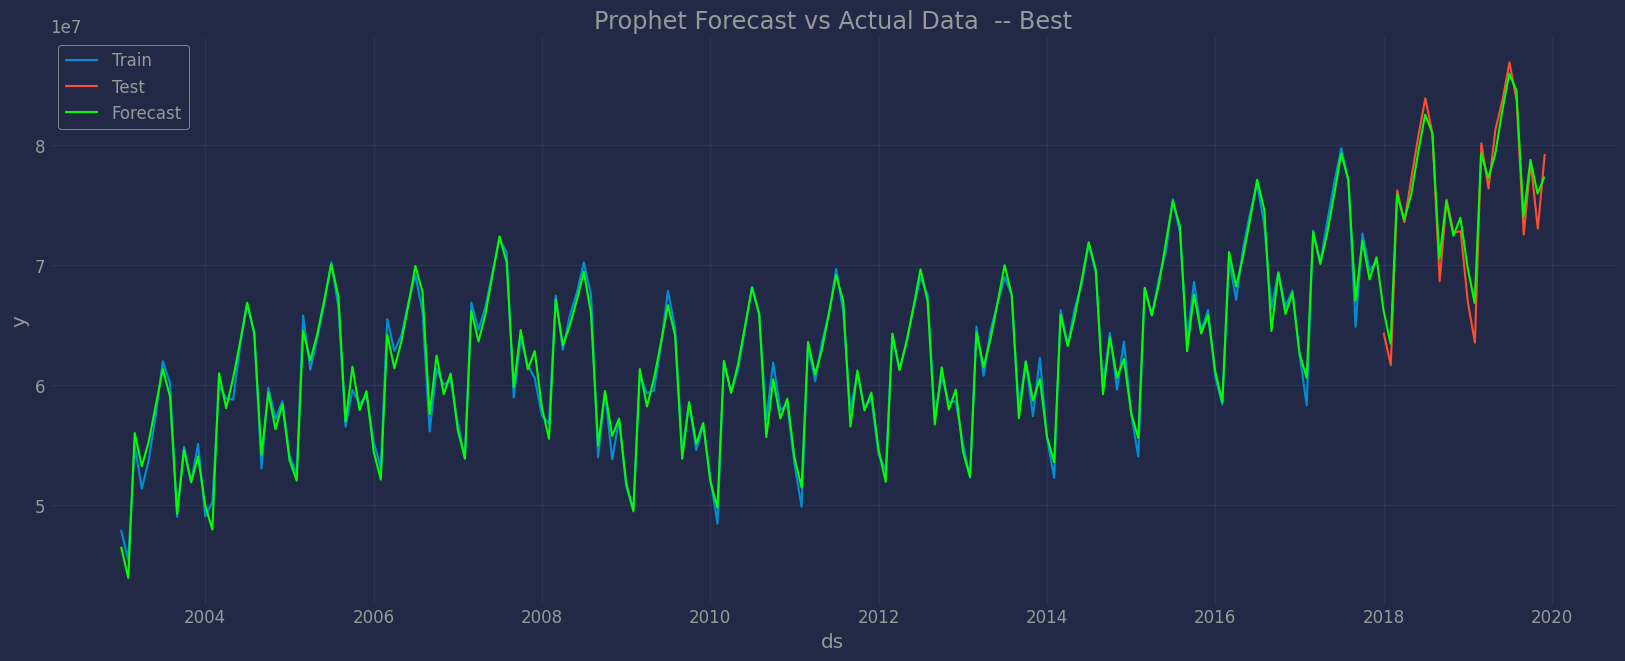

In [47]:
plt.figure(figsize=(18, 7))
sns.lineplot(data=train, x="ds", y="y", label="Train")
sns.lineplot(data=test, x="Date", y="Pax", label="Test")
sns.lineplot(data=forecast_best, x="ds", y="yhat", label="Forecast", color="lime")
plt.title("Prophet Forecast vs Actual Data  -- Best")
plt.grid(True)
plt.show()

In [48]:
plot_plotly(model, forecast_best)

In [50]:
plot_components_plotly(model, forecast_best)

In [52]:
forecast_best.tail(6)[["ds", "yhat", "yhat_lower", "yhat_upper"]].round()

,ds,yhat,yhat_lower,yhat_upper
198,2019-06-30,85987823.0,78913884.0,93109227.0
199,2019-07-31,84598601.0,77056763.0,91957891.0
200,2019-08-31,74055649.0,65937290.0,81979551.0
201,2019-09-30,78789407.0,69919143.0,87358503.0
202,2019-10-31,75971129.0,66500003.0,85343680.0
203,2019-11-30,77401716.0,67249799.0,87338871.0


### Performance evaluation

Cross-Validation for time series can be sometimes challenging, but the Prophet approach takes the hassle out of having to create your own function for a rolling forecast. We utilize the *cross_validation* function: the parameters to specify are the forecast horizon *horizon* and (optionally) size of the initial training period *initial* and the spacing between cutoff dates *period*. By default, the initial training period is set to three times the horizon, and cutoffs are made every half a horizon.

In [53]:
from prophet.diagnostics import cross_validation, performance_metrics

In [58]:
print(model.history["ds"].min(), model.history["ds"].max())

2003-01-01 00:00:00 2017-12-01 00:00:00


In [ ]:
df_cv = cross_validation(
    model, initial="4000 days", period="360 days", horizon="720 days"
)

  0%|          | 0/3 [00:00<?, ?it/s]

18:19:44 - cmdstanpy - INFO - Chain [1] start processing
18:19:44 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:01,  1.81it/s]18:19:44 - cmdstanpy - INFO - Chain [1] start processing
18:19:44 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:01<00:00,  2.01it/s]18:19:45 - cmdstanpy - INFO - Chain [1] start processing
18:19:45 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.09it/s]


La salida de *cross_validation* es un marco de datos donde para curoff (último punto de tiempo en el conjunto de entrenamiento) obtenemos una cantidad de valores:
* *ds* es el punto de tiempo en el conjunto de prueba.
* *y* es el valor verdadero en ds.
* *yhat_lower* y *yhat_upper* son los extremos inferior y superior del intervalo de confianza, respectivamente.

In [62]:
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2014-01-01,5.632683e+07,5.538714e+07,5.739267e+07,55628947.0,2013-12-22
1,2014-02-01,5.448912e+07,5.347783e+07,5.554923e+07,52283230.0,2013-12-22
2,2014-03-01,6.644966e+07,6.532417e+07,6.766679e+07,66265071.0,2013-12-22
3,2014-04-01,6.369824e+07,6.233071e+07,6.516569e+07,63341997.0,2013-12-22
4,2014-05-01,6.578646e+07,6.420497e+07,6.747170e+07,66368015.0,2013-12-22
...,...,...,...,...,...,...
67,2017-08-01,8.403819e+07,7.327936e+07,9.295059e+07,77047521.0,2015-12-12
68,2017-09-01,7.402606e+07,6.263672e+07,8.355415e+07,64870758.0,2015-12-12
69,2017-10-01,7.899738e+07,6.655802e+07,8.921912e+07,72655345.0,2015-12-12
70,2017-11-01,7.592386e+07,6.283906e+07,8.665365e+07,69590146.0,2015-12-12


Si bien es informativo, el objeto creado con cross_validation contiene abundante información. Esto se puede resumir de manera más sucinta agregando para generar métricas de desempeño:

In [ ]:
# Para conocer mejor los pronósticos obtenidos
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,69 days,3.047315e+12,1.745656e+06,1.512949e+06,0.026841,0.034936,0.026367,0.428571
1,74 days,2.994750e+12,1.730535e+06,1.462551e+06,0.025773,0.034936,0.025308,0.428571
2,80 days,4.358644e+12,2.087737e+06,1.814662e+06,0.030456,0.041398,0.029859,0.285714
3,100 days,3.734475e+12,1.932479e+06,1.562639e+06,0.026268,0.041398,0.025755,0.428571
4,105 days,3.039946e+12,1.743544e+06,1.256841e+06,0.020383,0.005624,0.019994,0.571429


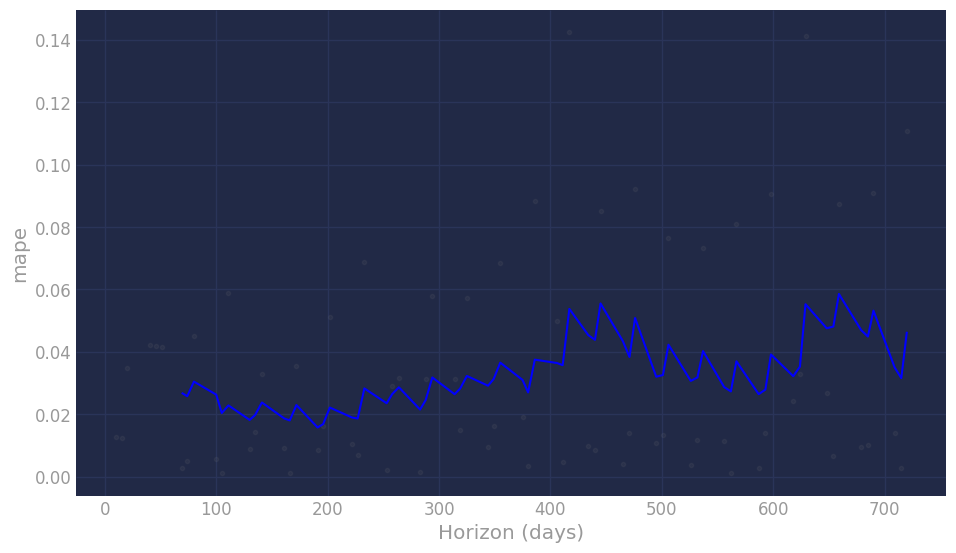

In [ ]:
from prophet.plot import plot_cross_validation_metric

fig = plot_cross_validation_metric(df_cv, metric="mape", rolling_window=0.1)
# La rolling window del video de la chica

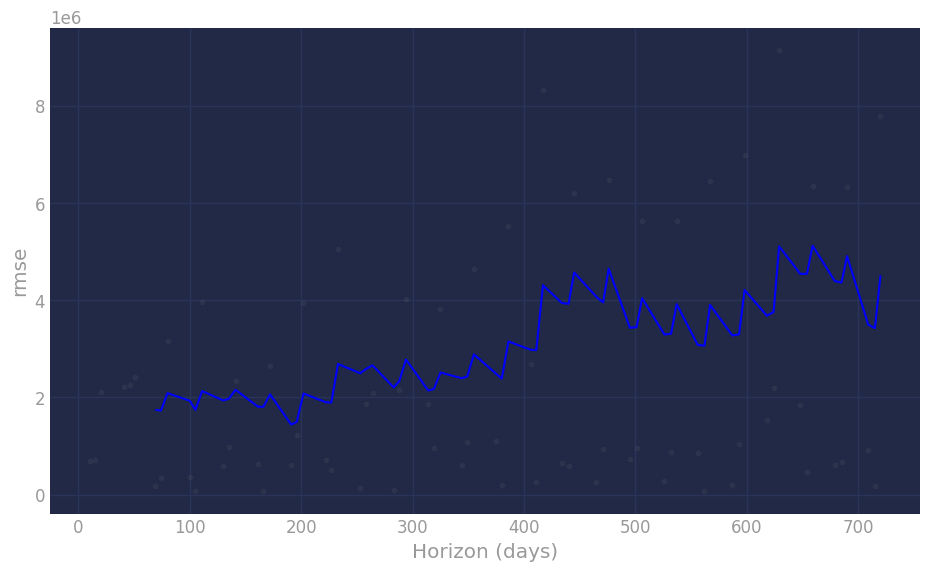

In [66]:
fig = plot_cross_validation_metric(df_cv, metric="rmse", rolling_window=0.1)